# Mining Challenge: Analyzing Developer Issues Presented to ChatGPT
Laura Salcido & Aryan Advaita
---

---

#### This notebook aims to answer the question:
What types of issues (bugs, feature requests, theoretical questions, etc.) do developers most commonly present to ChatGPT?

#### Approach:
Data Processing: Extract and clean data from the ChatgptSharing field, focusing on conversation prompts shared by developers.

#### Translation: 
Use the googletrans library to translate non-English prompts into English for consistent analysis.

#### Classification: 
Apply a custom keyword-based classifier to categorize prompts into predefined issue types:
- Bugs
- Feature Requests
- Theoretical Questions
- Performance/Optimization
- Discussion/Question
- School/Education
- Uncategorized
  
#### Analysis: 
Count the frequency of each issue type to identify trends.

#### Visualization: 
Create visual representations using a bar chart and pie chart to illustrate the distribution of issue types.

---

### Install Dependencies
Uncomment commands below and run dependencies

In [8]:
# !pip install langdetect
# !pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 854.3 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=ea5f5acb54f6bb04db778d47fafa843d536a3e209c152458dce9c4a005269a6d
  Stored in directory: /Users/laurasalcido/Library/Caches/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 

---

### Import libraries

In [206]:
import pandas as pd
import json
import os

from collections import defaultdict
from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


Testing with single file to analyze data structure

In [287]:
# file = "DevGPT/snapshot_20230727/20230727_195941_issue_sharings.json"

# with open(file, 'r', encoding='utf-8') as f:
#     data = json.load(f)

# df = pd.DataFrame(data)

# # Check for rows with nested dictionaries split into multiple columns
# if isinstance(df.iloc[0, 0], dict):  
#     combined_sources = df.apply(lambda row: [row[col] for col in df.columns if isinstance(row[col], dict)], axis=1)
#     expanded_sources = combined_sources.explode().apply(pd.Series)
#     result_df = pd.concat([df.drop(columns=df.columns, axis=1), expanded_sources], axis=1)

# print(result_df.head())

### Loading and Processing JSON Files in `issues_dir`
This code is designed to process multiple JSON files containing `issue-sharing` data. All `issue_sharings.json` files were consolidated into a new directory called `issues_dir` for better organization and processing.

In [109]:
directory_path = "issues_dir"  # new directory that holds all issue json files

json_files = [f for f in os.listdir(directory_path) if f.endswith('issue_sharings.json')]

for json_file in json_files:
    print(f"Found JSON file: {json_file} in {directory_path}")  # double check that file was found

result_df = pd.DataFrame()

for file in json_files:
    file_path = os.path.join(directory_path, file)

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    df = pd.DataFrame(data)

    if isinstance(df.iloc[0, 0], dict):  
        combined_sources = df.apply(lambda row: [row[col] for col in df.columns if isinstance(row[col], dict)], axis=1)
        expanded_sources = combined_sources.explode().apply(pd.Series)
        current_df = pd.concat([df.drop(columns=df.columns, axis=1), expanded_sources], axis=1)
    else:
        current_df = df  

result_df = pd.concat([result_df, current_df], ignore_index=True)

Found JSON file: 20230824_101836_issue_sharings.json in issues_dir
Found JSON file: 20230810_123938_issue_sharings.json in issues_dir
Found JSON file: 20230831_061759_issue_sharings.json in issues_dir
Found JSON file: 20230803_094705_issue_sharings.json in issues_dir
Found JSON file: 20230817_130502_issue_sharings.json in issues_dir
Found JSON file: 20230727_195941_issue_sharings.json in issues_dir


In [110]:
print(result_df.head())

    Type                                                URL            Author  \
0  issue  https://github.com/gakusyutai/gakusyutai.githu...            yuyu31   
1  issue  https://github.com/jabrena/aqa-tests-experimen...           jabrena   
2  issue  https://github.com/OpenVoiceOS/ovos-technical-...          JarbasAl   
3  issue      https://github.com/SKKUFastech/week1/issues/5           smh9800   
4  issue      https://github.com/SKKUFastech/week1/issues/4  woojinsung-jimmy   

                            RepoName RepoLanguage  Number  \
0    gakusyutai/gakusyutai.github.io         HTML      31   
1      jabrena/aqa-tests-experiments         Java       4   
2  OpenVoiceOS/ovos-technical-manual         None       4   
3                  SKKUFastech/week1            C       5   
4                  SKKUFastech/week1            C       4   

                                 Title  \
0                        ハンバーガーメニューの実装   
1  Run a test in multiple java distros   
2            documen

In [111]:
print(result_df.columns)

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title',
       'Body', 'CreatedAt', 'ClosedAt', 'UpdatedAt', 'State',
       'ChatgptSharing'],
      dtype='object')


In [112]:
print(result_df.shape)

(235, 13)


### Testing and exploring data
This block of code is a preliminary test to explore the structure and content of the ChatgptSharing column in the aggregated result_df DataFrame.

In [185]:
# TESTING
chatgpt_sharing_first_row = result_df['ChatgptSharing'].iloc[0]

if isinstance(chatgpt_sharing_first_row, str):
    chatgpt_sharing_first_row = json.loads(chatgpt_sharing_first_row)

chat_df = pd.json_normalize(chatgpt_sharing_first_row)

# print(chat_df['Conversations'])

example_keys = chatgpt_sharing_first_row[0].keys()
print("\nKeys in the chatgptsharing dictionary:", example_keys)

# check keys in conversations
conversations_data = chat_df['Conversations'].iloc[0]

if isinstance(conversations_data, str):
    conversations_data = json.loads(conversations_data)

if isinstance(conversations_data, list) and len(conversations_data) > 0:
    example_keys = conversations_data[0].keys()
    print("\nKeys in the Conversations dictionary:", example_keys)
else:
    print("\nNo valid data in Conversations.")


Keys in the chatgptsharing dictionary: dict_keys(['URL', 'Mention', 'Status', 'DateOfConversation', 'DateOfAccess', 'Title', 'NumberOfPrompts', 'TokensOfPrompts', 'TokensOfAnswers', 'Model', 'Conversations', 'HTMLContent'])

Keys in the Conversations dictionary: dict_keys(['Prompt', 'Answer', 'ListOfCode'])


### Create a classification method for determining type of prompt
This classify_issue_type function categorizes text prompts into specific issue types based on predefined keywords associated with each category. 

In [262]:
def classify_issue_type(prompt):
    prompt = prompt.lower()

    # Define keyword lists for each category
    bug_keywords = ['bug', 'error', 'errors', 'issue', 'broken', 'failure', 'does not work','problem', 'problems', "can't", 'unable']
    feature_request_keywords = ['feature', 'request', 'enhancement', 'add', 'include', 'create', 'implement', 'implemented']
    theoretical_question_keywords = ['how to', 'explanation', 'explain', 'define', 'describe', 'what if', 'how']
    performance_optimization_keywords = ['optimization', 'performance', 'improve', 'speed', 'faster', 'other', 'options', 'modify']
    discussion_question_keywords = ['question', 'discussion', 'debate', 'opinion', 'is it true', 'can I ask', 'why']
    school_education_keywords = ['school', 'project', 'class', 'assignment', 'classmate', 'student', 'professor']
    thanks_keywords = ['thank you', 'thanks', 'great']
    
    # Loop through each list and check for matching words in the prompt
    for keyword in bug_keywords:
        if keyword in prompt:
            return 'Bug'

    for keyword in feature_request_keywords:
        if keyword in prompt:
            return 'Feature Request'

    for keyword in theoretical_question_keywords:
        if keyword in prompt:
            return 'Theoretical Question'

    for keyword in performance_optimization_keywords:
        if keyword in prompt:
            return 'Performance/Optimization'

    for keyword in discussion_question_keywords:
        if keyword in prompt:
            return 'Discussion/Question'

    for keyword in school_education_keywords:
        if keyword in prompt:
            return 'School/Education'

    for keyword in thanks_keywords:
        if keyword in prompt:
            return 'Thanks'
            
    return 'Uncategorized'


### Initialize a dictionary to keep track of issue type counts


In [263]:
issue_type_counts = {
    'Bug': 0,
    'Feature Request': 0,
    'Theoretical Question': 0,
    'Performance/Optimization': 0,
    'Discussion/Question': 0,
    'School/Education': 0,
    'Thanks':0,
    'Uncategorized': 0
}

### Translate and check prompts

Some prompts are in different languages, here we are translating the conversations to english.

In [264]:
translator = Translator()

# Initialize a counter
processed_rows = 0
max_rows = 200  # set limit for rows
issue_type_counts = defaultdict(int)

# Placeholder for prompts and labels
prompts = []
labels = []

for index, row in result_df.iterrows():
    if processed_rows >= max_rows:
        break  # Stop processing after reaching the limit
        
    chatgpt_sharing = row['ChatgptSharing']

    if isinstance(chatgpt_sharing, str):
        try:
            chatgpt_sharing = json.loads(chatgpt_sharing)
        except json.JSONDecodeError as e:
            print(f"Row {index + 1}: Error decoding JSON: {e}")
            continue

    if isinstance(chatgpt_sharing, list):
        for item in chatgpt_sharing:
            if not isinstance(item, dict) or 'Conversations' not in item:
                continue

            conversations_data = item['Conversations']
            if isinstance(conversations_data, list):
                for i, conversation in enumerate(conversations_data, start=1):
                    prompt = conversation.get('Prompt', None)

                    if not prompt or not isinstance(prompt, str):
                        # print(f"Missing 'Prompt'")
                        continue
                    try:
                        translated_prompt = translator.translate(prompt, src='auto', dest='en').text
                        prompts.append(translated_prompt)
                        
                        # Classify the issue 
                        issue_type = classify_issue_type(translated_prompt)
                        labels.append(issue_type)
                        # print(issue_type)

                        # Update the issue type count
                        issue_type_counts[issue_type] += 1
                    except Exception as e:
                        continue
                        
    elif isinstance(chatgpt_sharing, dict) and 'Conversations' in chatgpt_sharing:
        conversations_data = chatgpt_sharing['Conversations']

        if isinstance(conversations_data, list):
            for i, conversation in enumerate(conversations_data, start=1):
                prompt = conversation.get('Prompt', None)

                if not prompt or not isinstance(prompt, str):
                    # print(f"Invalid or missing 'Prompt'")
                    continue

                try:
                    translated_prompt = translator.translate(prompt, src='auto', dest='en').text
                    prompts.append(translated_prompt)
                    
                    # Classify the issue 
                    issue_type = classify_issue_type(translated_prompt)
                    labels.append(issue_type)
                    
                    # Update the issue type count
                    issue_type_counts[issue_type] += 1
                except Exception as e:
                    continue

        else:
            print(f"'Conversations' is not a list.")
    else:
        print(f"'ChatgptSharing' is not a valid list or dict.")

    processed_rows += 1

# print(issue_type_counts)

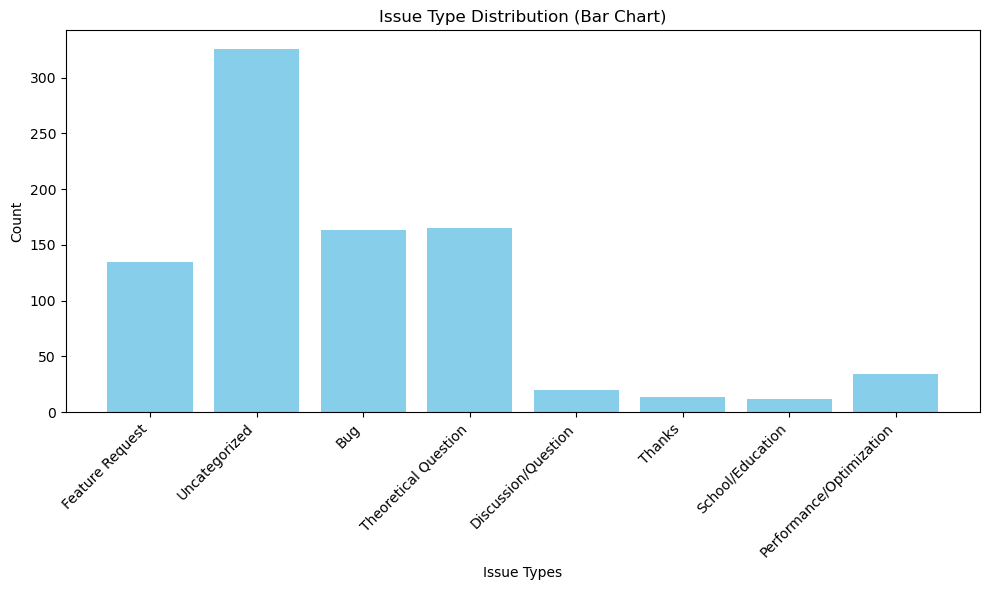

In [265]:
import matplotlib.pyplot as plt

# Bar chart 
chart_labels = issue_type_counts.keys()
counts = issue_type_counts.values()

plt.figure(figsize=(10, 6))
plt.bar(chart_labels, counts, color='skyblue')
plt.title('Issue Type Distribution (Bar Chart)')
plt.xlabel('Issue Types')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


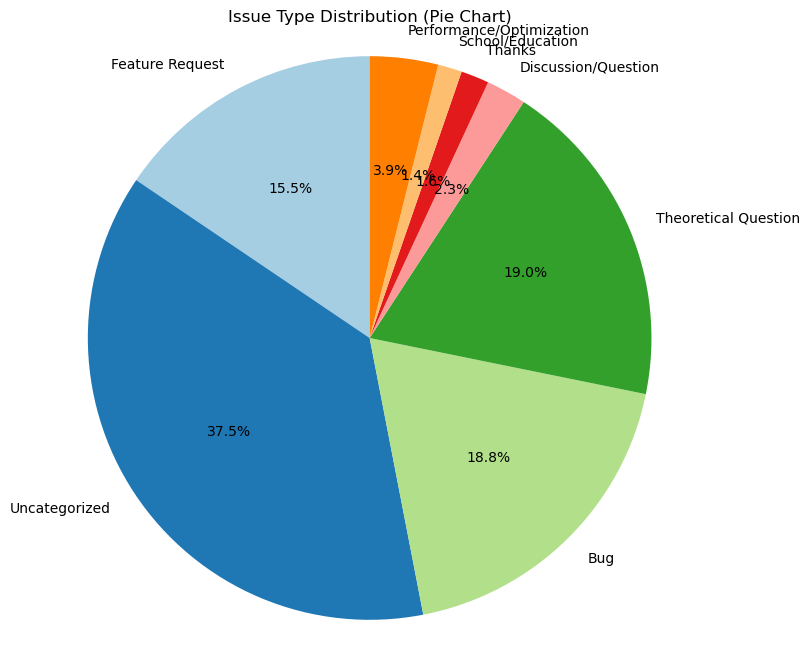

defaultdict(<class 'int'>, {'Feature Request': 135, 'Uncategorized': 326, 'Bug': 163, 'Theoretical Question': 165, 'Discussion/Question': 20, 'Thanks': 14, 'School/Education': 12, 'Performance/Optimization': 34})


In [266]:
# Pie chart 
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=chart_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Issue Type Distribution (Pie Chart)')
plt.axis('equal')  
plt.show()

print(issue_type_counts)

### Testing for Accuracy of Keyword method

In [267]:
data = {
    "prompts": prompts,
    "labels": labels
}

df = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(
    df["prompts"], df["labels"], test_size=0.2, random_state=42
)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# predictions
y_pred = classifier.predict(X_test_tfidf)

# classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                          precision    recall  f1-score   support

                     Bug       0.93      0.72      0.81        36
     Discussion/Question       0.00      0.00      0.00         4
         Feature Request       0.73      0.34      0.47        32
Performance/Optimization       0.00      0.00      0.00         4
                  Thanks       0.00      0.00      0.00         1
    Theoretical Question       0.81      0.71      0.76        35
           Uncategorized       0.61      0.98      0.75        62

                accuracy                           0.71       174
               macro avg       0.44      0.39      0.40       174
            weighted avg       0.71      0.71      0.67       174



/Users/laurasalcido/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laurasalcido/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laurasalcido/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

### K-Means Implementation

In [284]:
# K-means implementation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

issue_type_counts_kmeans = defaultdict(int)
categorized_issue_type_counts_kmeans = {
    'Bug': 0,
    'Feature Request': 0,
    'Theoretical Question': 0,
    'Performance/Optimization': 0,
    'Discussion/Question': 0,
    'School/Education': 0,
    'Thanks':0,
    'Uncategorized': 0
}

data = { "prompts": prompts }

df = pd.DataFrame(data)

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(df["prompts"])

# Apply K-Means Clustering
num_clusters = 8  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

df["cluster"] = kmeans.labels_

for cluster_label in df["cluster"]:
    issue_type_counts_kmeans[cluster_label] += 1

prompt_count = 0

print("\nClustering Results:")
for cluster_num in range(num_clusters):
    cluster_prompts = df[df["cluster"] == cluster_num]["prompts"].to_list()
    first_prompt = cluster_prompts[0]
    classified_type = classify_issue_type(first_prompt)
    # categorize results using the classification method
    if (categorized_issue_type_counts_kmeans[classified_type] == 0):
        categorized_issue_type_counts_kmeans[classified_type] = issue_type_counts_kmeans[cluster_num]
    else:
        while categorized_issue_type_counts_kmeans[classified_type] != 0 and prompt_count < cluster_num:
            prompt_count += 1
            next_prompt = cluster_prompts[prompt_count]
            classified_type = classify_issue_type(next_prompt)
            if (categorized_issue_type_counts_kmeans[classified_type] == 0):
                categorized_issue_type_counts_kmeans[classified_type] = issue_type_counts_kmeans[cluster_num]
        print(f"{classified_type}: {issue_type_counts_kmeans[cluster_num]} prompts")


Clustering Results:
Bug: 46 prompts
Thanks: 37 prompts
Uncategorized: 9 prompts
Theoretical Question: 50 prompts
School/Education: 61 prompts


### Categorizing again with K-means results

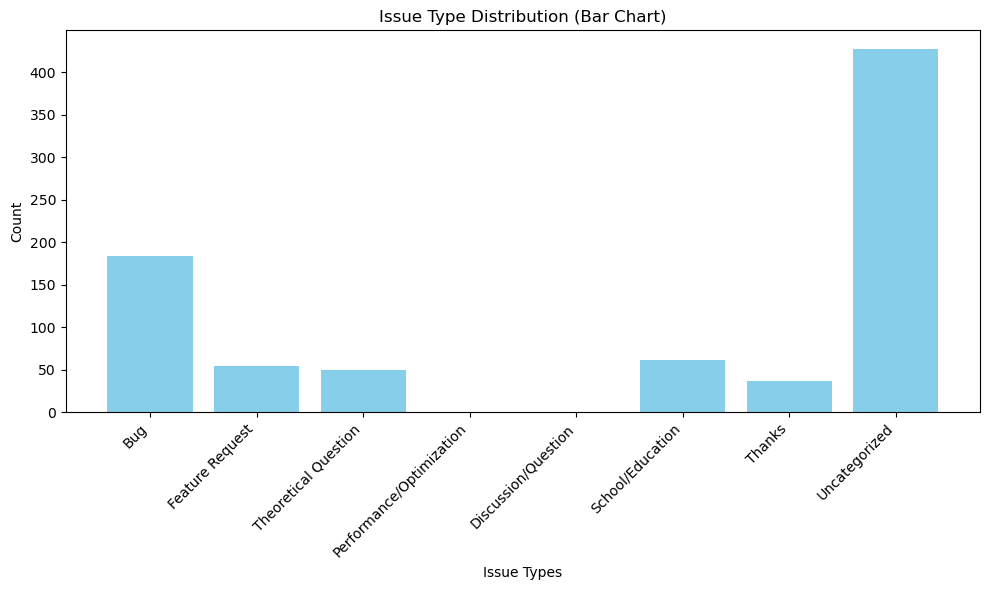

In [286]:
chart_labels = categorized_issue_type_counts_kmeans.keys()
counts = categorized_issue_type_counts_kmeans.values()

plt.figure(figsize=(10, 6))
plt.bar(chart_labels, counts, color='skyblue')
plt.title('Issue Type Distribution (Bar Chart)')
plt.xlabel('Issue Types')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Summary:
#### Top categories: 
Uncategorized, Bug, and Feature Request. There were a lot more uncategorized prompts when using k-means.
#### Improvement areas: 
Reduce the high count of Uncategorized by refining keyword sets or adding more specific categories.